In [144]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will l

In [144]:
ist all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dataset1/train.txt


# Installing Libraries and necessary packages

In [ ]:
 conda install -y gdown

In [ ]:
import gdown 
url = 'https://drive.google.com/file/d/1xdHFkMvf4DeHSfP1g1-C34effao6FMlV/view?usp=sharing' 
output = 'train.zip'
gdown.download(url, output)

In [ ]:
! pip install rdkit-pypi
! pip install drug-smile-fet

# IMPORTING NECESSASARY LIBRARIES

In [227]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from sklearn.cluster import DBSCAN, SpectralClustering, KMeans,AgglomerativeClustering,OPTICS
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import ast
import warnings
warnings.filterwarnings("ignore")

# Reading Dataset

In [279]:
df=pd.read_csv('/kaggle/input/dataset1/train.txt')
# df=df.head(5000)
df= df.sample(n=30000, random_state=42) 
df

,SMILES,SPLIT
760966,O=C(NC1CC1)c1cc(NC(=O)C2CC=CCC2)ccc1Cl,train
80229,Cc1cnc(NC(=O)c2ccc(OCC(C)C)cc2)s1,train
1388158,COc1ccsc1C(=O)NCC1CN2CCCCC2CO1,train
851927,CN(C)S(=O)(=O)NCc1ccccc1Oc1ccccc1,train
735447,CS(=O)(=O)c1ccc(CNC(=O)COc2cccc(C#N)c2)cc1,train
...,...,...
891327,CCOc1ccc(NC(=O)C(C)Sc2nnnn2C2CC2)c(C)c1,train
792055,COc1ccc(Cc2nc3cc4c(cc3[nH]2)OCCO4)cc1OC,train
794680,CC(c1nc(N)nc(N(C)C)n1)N1CCN(CC(F)F)CC1,train
1461853,COCCC1(CNC(=O)Nc2ccc(C(C)(C)C)nn2)CC1,train


# Removing Duplicates

In [280]:
df_no_duplicates = df.drop_duplicates(subset='SMILES')
print(df_no_duplicates)

                                             SMILES  SPLIT
760966       O=C(NC1CC1)c1cc(NC(=O)C2CC=CCC2)ccc1Cl  train
80229             Cc1cnc(NC(=O)c2ccc(OCC(C)C)cc2)s1  train
1388158              COc1ccsc1C(=O)NCC1CN2CCCCC2CO1  train
851927            CN(C)S(=O)(=O)NCc1ccccc1Oc1ccccc1  train
735447   CS(=O)(=O)c1ccc(CNC(=O)COc2cccc(C#N)c2)cc1  train
...                                             ...    ...
891327      CCOc1ccc(NC(=O)C(C)Sc2nnnn2C2CC2)c(C)c1  train
792055      COc1ccc(Cc2nc3cc4c(cc3[nH]2)OCCO4)cc1OC  train
794680       CC(c1nc(N)nc(N(C)C)n1)N1CCN(CC(F)F)CC1  train
1461853       COCCC1(CNC(=O)Nc2ccc(C(C)(C)C)nn2)CC1  train
1519465        COCCNc1nc2ccccc2n2nc(C(=O)N(C)C)nc12  train

[30000 rows x 2 columns]


# Feature Extraction

In [230]:
smiles_list = df['SMILES']

def extract_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        descriptors = [Descriptors.MolWt(mol), Descriptors.TPSA(mol), Descriptors.NumHAcceptors(mol), Descriptors.NumHDonors(mol), Descriptors.HeavyAtomCount(mol), Descriptors.MolLogP(mol), Descriptors.NumRotatableBonds(mol), Descriptors.RingCount(mol),Descriptors.NumAromaticRings(mol),Descriptors.FractionCSP3(mol)]
        return descriptors
    else:
        return [None] * 4  # Return None for invalid SMILES

descriptors_df = pd.DataFrame(smiles_list.apply(extract_descriptors).tolist(),
                               columns=['MolecularWeight', 'TopologicalPolarSurfaceArea', 'NumHAcceptors', 'NumHDonors','HeavyAtomCount','MolLogP','NumRotatableBonds','RingCount','NumAromaticRings','FractionCSP3'])

df = pd.concat([df, descriptors_df], axis=1)

# Display the DataFrame with extracted descriptors
df

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import OPTICS
from sklearn.metrics import silhouette_score
from sklearn.cluster import SpectralClustering
from sklearn.cluster import Birch
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import seaborn as sns
features = df[['MolecularWeight', 'TopologicalPolarSurfaceArea', 'NumHAcceptors', 'NumHDonors','HeavyAtomCount','MolLogP','NumRotatableBonds','RingCount','NumAromaticRings','FractionCSP3']]
df=df.drop(['SPLIT'],axis=1)
df1=df
df1

,SMILES,MolecularWeight,TopologicalPolarSurfaceArea,NumHAcceptors,NumHDonors,HeavyAtomCount,MolLogP,NumRotatableBonds,RingCount,NumAromaticRings,FractionCSP3
0,CCCS(=O)c1ccc2[nH]c(=NC(=O)OC)[nH]c2c1,281.337,87.31,3,2,19,1.68070,3,2,2,0.333333
1,CC(C)(C)C(=O)C(Oc1ccc(Cl)cc1)n1ccnc1,292.766,44.12,4,0,20,3.72930,4,2,2,0.333333
2,Cc1c(Cl)cccc1Nc1ncccc1C(=O)OCC(O)CO,336.775,91.68,6,3,23,2.29702,6,2,2,0.250000
3,Cn1cnc2c1c(=O)n(CC(O)CO)c(=O)n2C,254.246,102.28,8,2,18,-2.21310,3,2,2,0.500000
4,CC1Oc2ccc(Cl)cc2N(CC(O)CO)C1=O,271.700,70.00,4,2,18,0.80710,3,2,1,0.416667
...,...,...,...,...,...,...,...,...,...,...,...
4995,Nc1ncnc(Nc2ccc(Cl)c(Cl)c2)n1,256.096,76.72,5,2,16,2.50420,2,2,2,0.000000
4996,Cc1cc(NC(=O)c2ccc(S(=O)(=O)N(C)C)cc2)no1,309.347,92.51,5,1,21,1.48562,4,2,2,0.230769
4997,Cc1ccc(Sc2c(C)nn(C(=O)c3cccnc3)c2C)cc1,323.421,47.78,5,0,23,4.04306,3,3,3,0.166667
4998,O=C(c1cc(F)c(F)cc1Cl)N1CCCCCC1,273.710,20.31,1,0,18,3.63440,1,2,1,0.461538


# Applying brute force best suited

Final Cluster Assignments:
                                        SMILES  ensemble_cluster
0       CCCS(=O)c1ccc2[nH]c(=NC(=O)OC)[nH]c2c1                 0
1         CC(C)(C)C(=O)C(Oc1ccc(Cl)cc1)n1ccnc1                 0
2          Cc1c(Cl)cccc1Nc1ncccc1C(=O)OCC(O)CO                 0
3             Cn1cnc2c1c(=O)n(CC(O)CO)c(=O)n2C                 0
4               CC1Oc2ccc(Cl)cc2N(CC(O)CO)C1=O                 0
...                                        ...               ...
4995              Nc1ncnc(Nc2ccc(Cl)c(Cl)c2)n1                 0
4996  Cc1cc(NC(=O)c2ccc(S(=O)(=O)N(C)C)cc2)no1                 0
4997    Cc1ccc(Sc2c(C)nn(C(=O)c3cccnc3)c2C)cc1                 0
4998            O=C(c1cc(F)c(F)cc1Cl)N1CCCCCC1                 0
4999    Cc1ccccc1-c1nnn(CC(=O)Nc2cccc(C)c2C)n1                 0

[5000 rows x 2 columns]
Silhouette Score: 0.43539212141808636


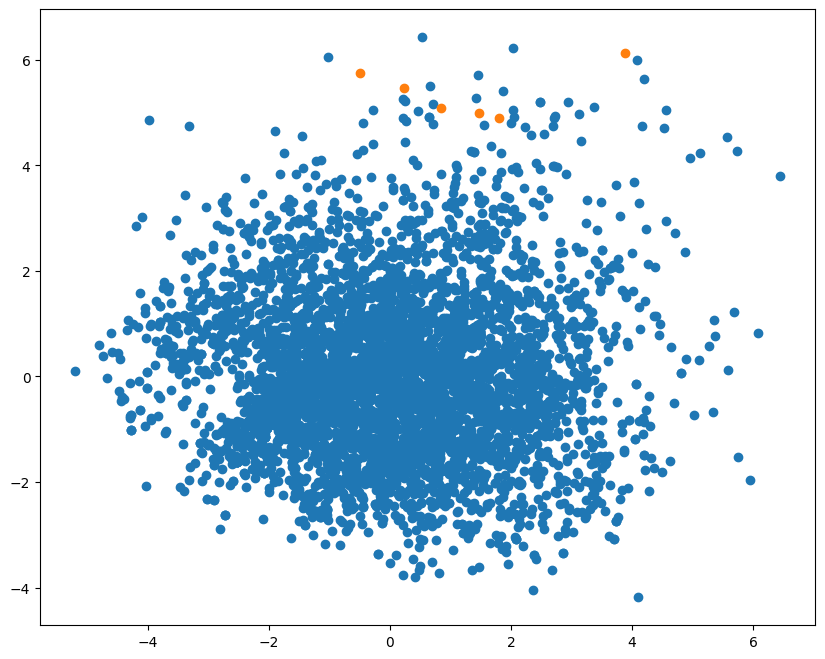

In [232]:
scaled_features = StandardScaler().fit_transform(features)
dbscan = DBSCAN(eps=2, min_samples=5)
spectral = SpectralClustering(n_clusters=2, random_state=42)
kmeans = KMeans(n_clusters=3, random_state=42)
agglomerative = AgglomerativeClustering(n_clusters=3)
birch = Birch(n_clusters=3, threshold=0.5, branching_factor=50)
dbscan_clusters = dbscan.fit_predict(scaled_features)
spectral_clusters = spectral.fit_predict(scaled_features)
kmeans_clusters = kmeans.fit_predict(scaled_features)
birch_clusters = birch.fit_predict(scaled_features)
agglomerative_clusters = agglomerative.fit_predict(scaled_features)

# Create a clustering ensemble by combining results
ensemble_clusters = np.vstack((dbscan_clusters, spectral_clusters))

# Apply majority voting to get the final ensemble result
final_clusters = np.apply_along_axis(lambda x: np.argmax(np.bincount(x[x != -1])), axis=0, arr=ensemble_clusters)

# Add the final clusters to the DataFrame
df['ensemble_cluster'] = final_clusters

# Print the final cluster assignments
print("Final Cluster Assignments:")
print(df[['SMILES', 'ensemble_cluster']])

# Evaluate the ensemble technique using Silhouette Score
non_noise_df = df[df['ensemble_cluster'] != -1]
non_noise_features = scaled_features[df['ensemble_cluster'] != -1]
silhouette_score_value = silhouette_score(non_noise_features, non_noise_df['ensemble_cluster'])
print(f'Silhouette Score: {silhouette_score_value}')
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assuming 'scaled_features' is your scaled feature matrix
# You can replace this with your actual feature matrix
scaled_features = StandardScaler().fit_transform(features)

# Apply PCA to reduce dimensionality to 2 components
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)

# Plot the clusters
plt.figure(figsize=(10, 8))

# Plot each cluster with a different color
for cluster in np.unique(final_clusters):
    cluster_points = reduced_features[df['ensemble_cluster'] == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}')

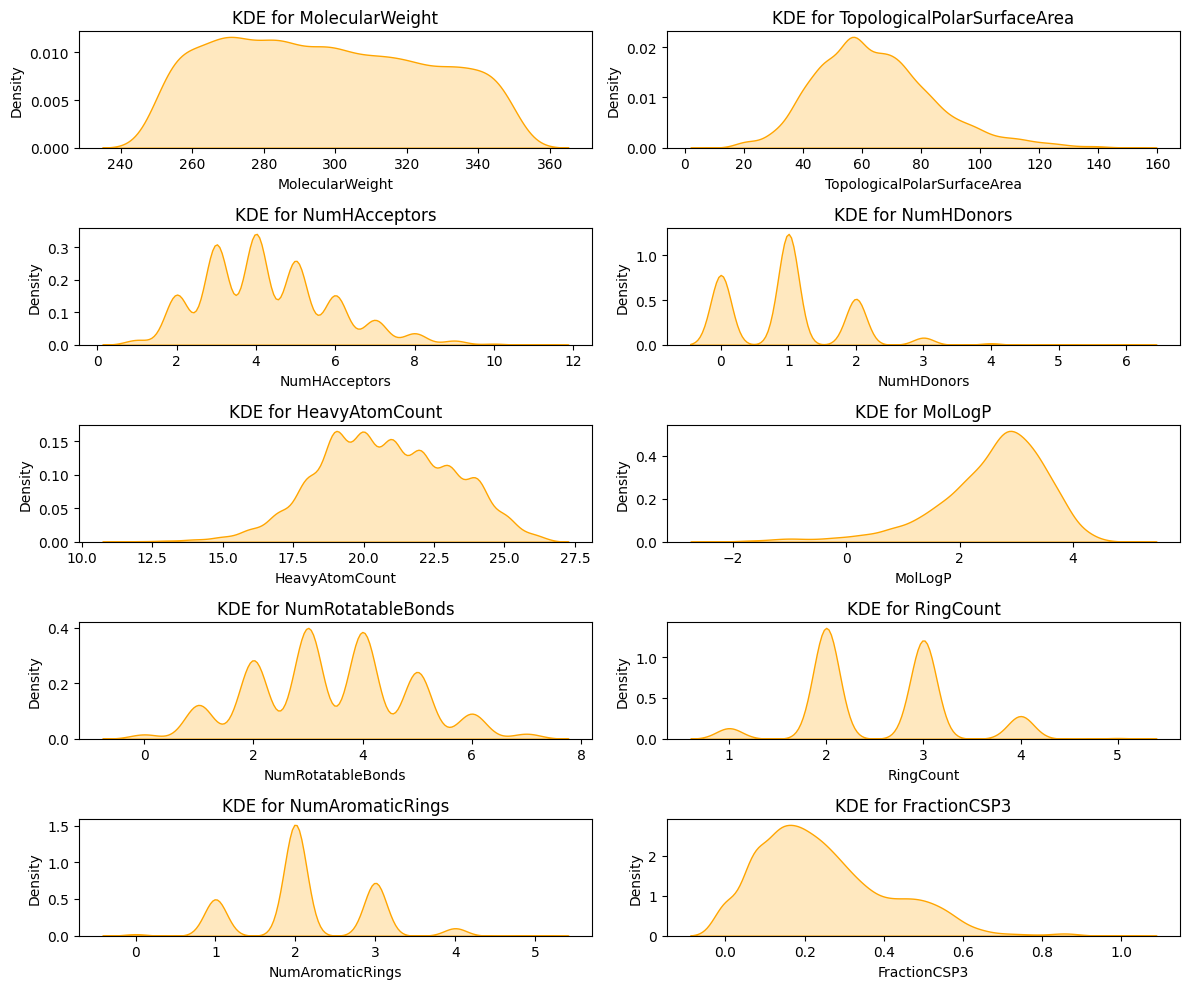

In [234]:
columns_to_plot = ['MolecularWeight', 'TopologicalPolarSurfaceArea', 'NumHAcceptors', 'NumHDonors','HeavyAtomCount','MolLogP','NumRotatableBonds','RingCount','NumAromaticRings','FractionCSP3']
fig, axes = plt.subplots(nrows=len(columns_to_plot)//2, ncols=2, figsize=(12, 10))
axes = axes.flatten()
for i, column in enumerate(columns_to_plot):
    sns.kdeplot(data=df, x=column, ax=axes[i], fill=True,color='orange')
    axes[i].set_title(f'KDE for {column}')
if len(columns_to_plot) % 2 != 0:
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

# Correlation Matrix

In [236]:
numeric_features = df.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numeric_features.corr()
correlation_matrix


,MolecularWeight,TopologicalPolarSurfaceArea,NumHAcceptors,NumHDonors,HeavyAtomCount,MolLogP,NumRotatableBonds,RingCount,NumAromaticRings,FractionCSP3,ensemble_cluster
MolecularWeight,1.000000,0.309629,0.268462,0.106320,0.794490,0.120796,0.325645,0.284608,0.191152,0.008083,0.008059
TopologicalPolarSurfaceArea,0.309629,1.000000,0.681462,0.551708,0.348370,-0.595749,0.199141,0.087126,0.134680,-0.002697,0.073373
NumHAcceptors,0.268462,0.681462,1.000000,0.002215,0.289145,-0.496651,0.111589,0.300493,0.324557,0.092636,0.037143
NumHDonors,0.106320,0.551708,0.002215,1.000000,0.122334,-0.190262,0.171490,-0.077566,-0.021438,-0.129383,0.174723
HeavyAtomCount,0.794490,0.348370,0.289145,0.122334,1.000000,0.101164,0.331070,0.496903,0.360104,-0.033969,-0.016021
MolLogP,0.120796,-0.595749,-0.496651,-0.190262,0.101164,1.000000,-0.018466,0.111370,0.238769,-0.352946,-0.105911
NumRotatableBonds,0.325645,0.199141,0.111589,0.171490,0.331070,-0.018466,1.000000,-0.323512,-0.080539,0.101428,0.006308
RingCount,0.284608,0.087126,0.300493,-0.077566,0.496903,0.111370,-0.323512,1.000000,0.684654,-0.235817,-0.034199
NumAromaticRings,0.191152,0.134680,0.324557,-0.021438,0.360104,0.238769,-0.080539,0.684654,1.000000,-0.660446,-0.051463
FractionCSP3,0.008083,-0.002697,0.092636,-0.129383,-0.033969,-0.352946,0.101428,-0.235817,-0.660446,1.000000,0.055536


# Heatmap


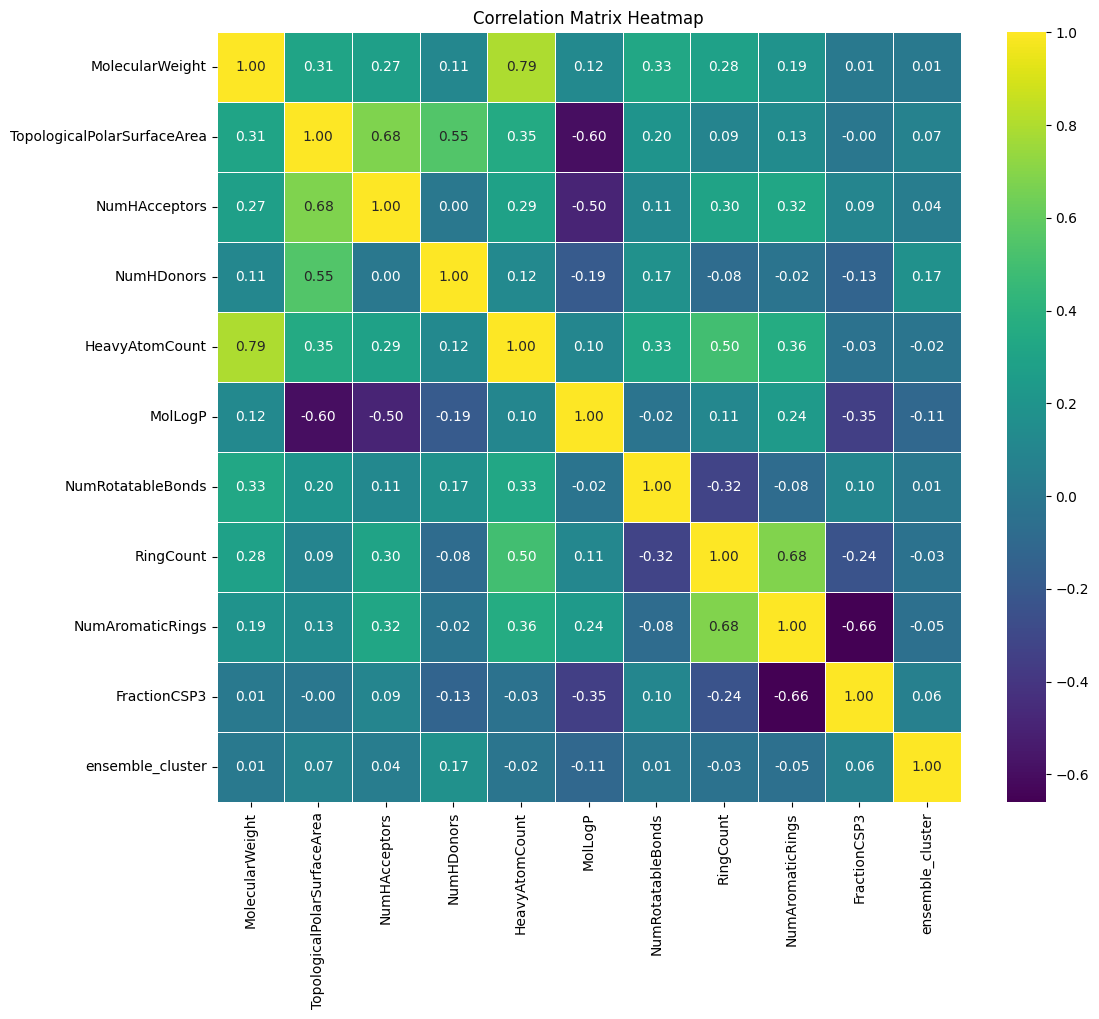

In [237]:
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

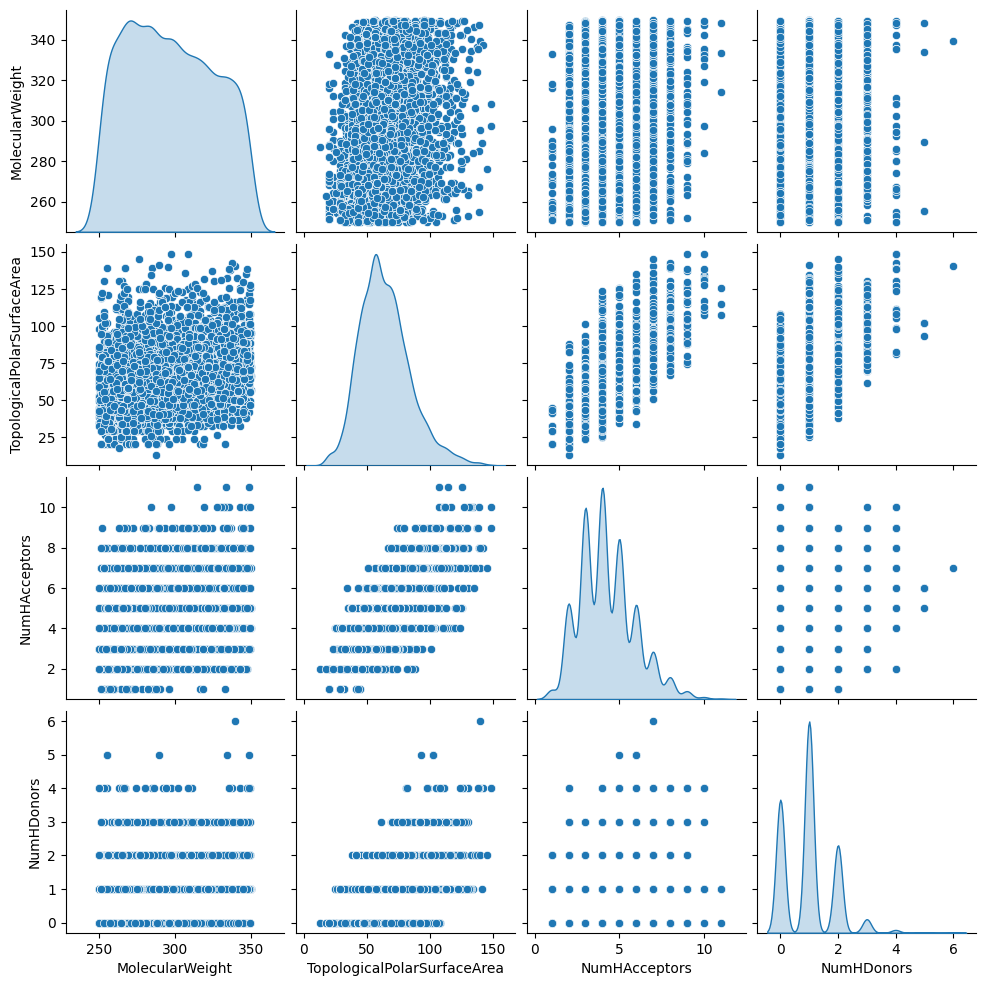

In [238]:
sns.pairplot(df[['MolecularWeight', 'TopologicalPolarSurfaceArea', 'NumHAcceptors', 'NumHDonors']], diag_kind='kde')
plt.show()

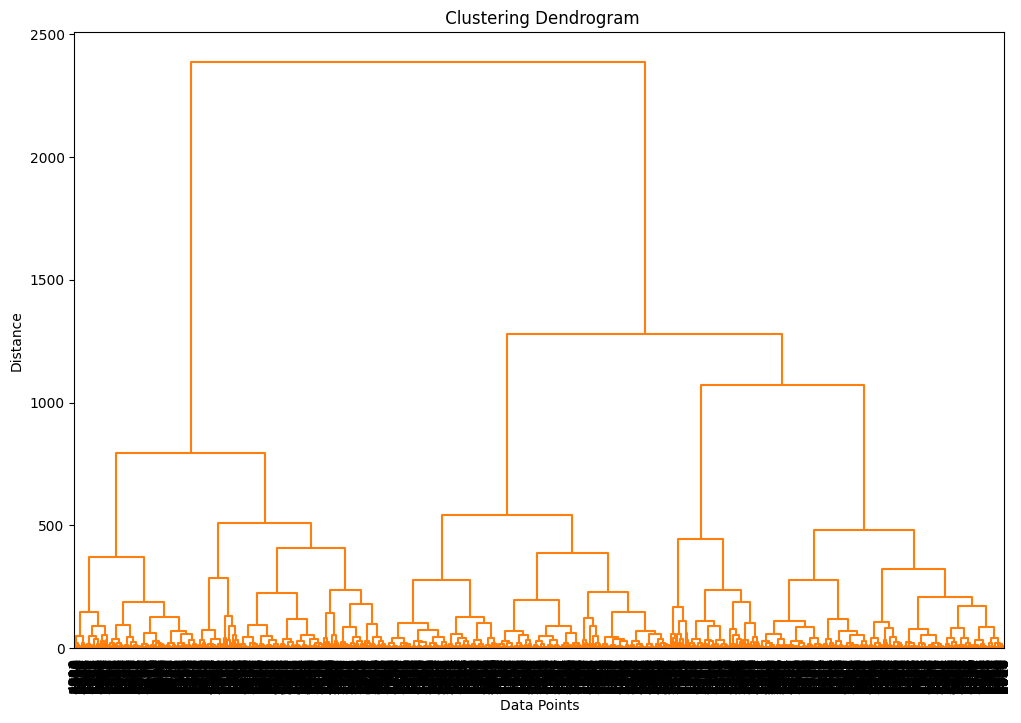

In [239]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist

# Assuming 'features' contains the feature columns
features = df[['MolecularWeight', 'TopologicalPolarSurfaceArea', 'NumHAcceptors', 'NumHDonors']]

# Calculate pairwise distances
distance_matrix = pdist(features, metric='euclidean')

# Perform hierarchical/agglomerative clustering
linkage_matrix = hierarchy.linkage(distance_matrix, method='ward')

# Plot the dendrogram
plt.figure(figsize=(12, 8))
dendrogram = hierarchy.dendrogram(linkage_matrix, labels=df.index, orientation='top', leaf_font_size=10, color_threshold=np.inf)
plt.title(' Clustering Dendrogram')
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.show()


<Figure size 1200x1000 with 0 Axes>

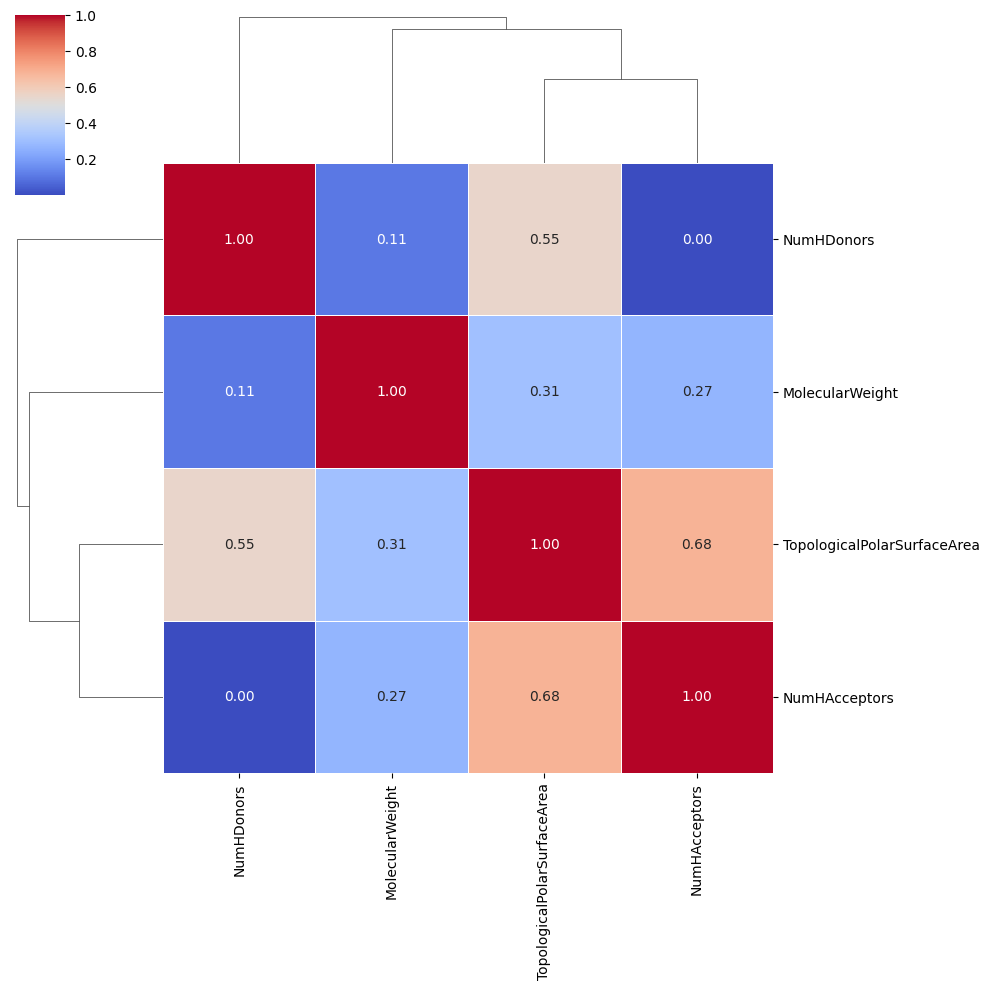

In [240]:
corr_matrix = features.corr()
plt.figure(figsize=(12, 10))
sns.clustermap(corr_matrix, cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5)
plt.show()


# Dropping unnecesaary features

In [241]:
df=df.drop(['HeavyAtomCount','RingCount','MolLogP','NumRotatableBonds','NumAromaticRings','FractionCSP3'],axis=1)

In [242]:
df1=df

In [243]:
df=df.drop(['ensemble_cluster'],axis=1)
df1=df

# Applying K Means Clustering

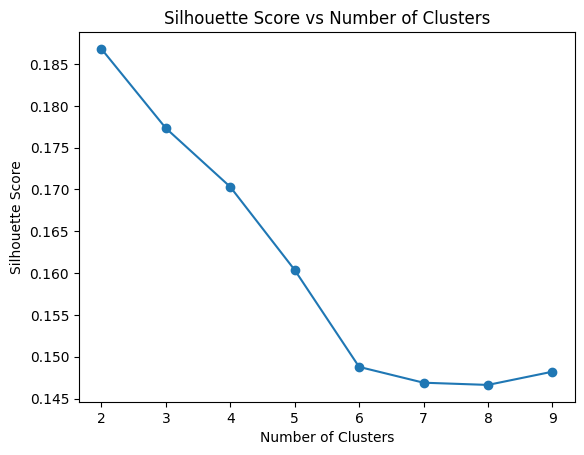

In [245]:
# Store silhouette scores for each cluster value
silhouette_scores = []

# Iterate over different cluster values
for num_clusters in cluster_range:
    # Apply K-Means Clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    df['cluster'] = kmeans.fit_predict(scaled_features)

    # Calculate Silhouette Score
    silhouette_avg = silhouette_score(scaled_features, df['cluster'])
    silhouette_scores.append(silhouette_avg)

# Plot the Silhouette Scores for different cluster values
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.show()
df=df1

# Applying Optics 

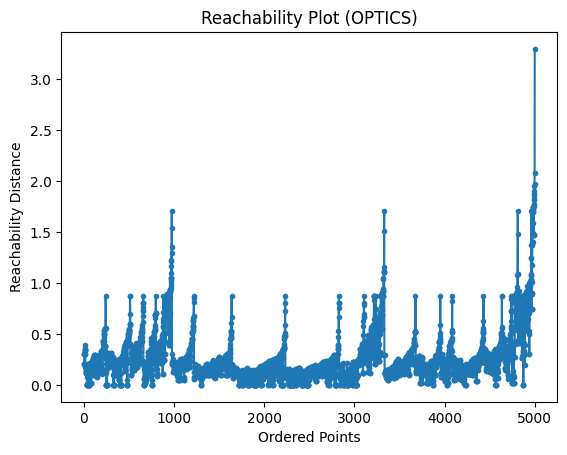

Estimated Number of Clusters: 356


In [246]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import OPTICS
from sklearn.preprocessing import StandardScaler

# Assuming 'SMILES' is the column in your DataFrame
smiles_list = df['SMILES']

# Function to extract molecular descriptors from SMILES
def extract_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        descriptors = [Descriptors.MolWt(mol), Descriptors.TPSA(mol), Descriptors.NumHAcceptors(mol), Descriptors.NumHDonors(mol)]
        return descriptors
    else:
        return [None] * 4  # Return None for invalid SMILES

# Apply the function to each SMILES in the DataFrame
descriptors_df = pd.DataFrame(smiles_list.apply(extract_descriptors).tolist(),
                               columns=['MolecularWeight', 'TopologicalPolarSurfaceArea', 'NumHAcceptors', 'NumHDonors'])

# Concatenate the original DataFrame with the extracted descriptors
df = pd.concat([df, descriptors_df], axis=1)

# Select the relevant columns as features for clustering
features = df[['MolecularWeight', 'TopologicalPolarSurfaceArea', 'NumHAcceptors', 'NumHDonors']]

# Use StandardScaler to scale the features
scaled_features = StandardScaler().fit_transform(features)

# Apply OPTICS Clustering
optics = OPTICS(min_samples=5, max_eps=50)
df['cluster'] = optics.fit_predict(scaled_features)

# Plot the reachability plot
reachability = optics.reachability_[optics.ordering_]
plt.plot(reachability, marker='.')
plt.title('Reachability Plot (OPTICS)')
plt.xlabel('Ordered Points')
plt.ylabel('Reachability Distance')
plt.show()

# Extract clusters from the reachability plot
optimal_clusters = len(set(df['cluster'])) - 1  # Excluding noise points (-1)
print(f"Estimated Number of Clusters: {optimal_clusters}")
df=df1

# Applying Birch Technique

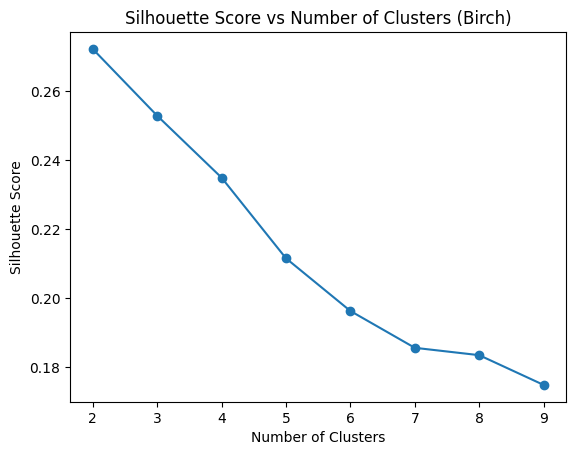

Optimal Number of Clusters: 2


In [247]:
# Store silhouette scores for each cluster value
silhouette_scores = []

# Iterate over different cluster values
for num_clusters in cluster_range:
    # Apply Birch Clustering
    birch = Birch(n_clusters=num_clusters, threshold=0.5, branching_factor=50)
    df['cluster'] = birch.fit_predict(scaled_features)

    # Calculate Silhouette Score
    silhouette_avg = silhouette_score(scaled_features, df['cluster'])
    silhouette_scores.append(silhouette_avg)

# Plot the Silhouette Scores for different cluster values
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters (Birch)')
plt.show()

# Find the optimal number of clusters
optimal_clusters = cluster_range[silhouette_scores.index(max(silhouette_scores))]
print(f"Optimal Number of Clusters: {optimal_clusters}")
df=df.drop(['cluster'],axis=1)
df=df1

# Applying Agglomerative Clustering

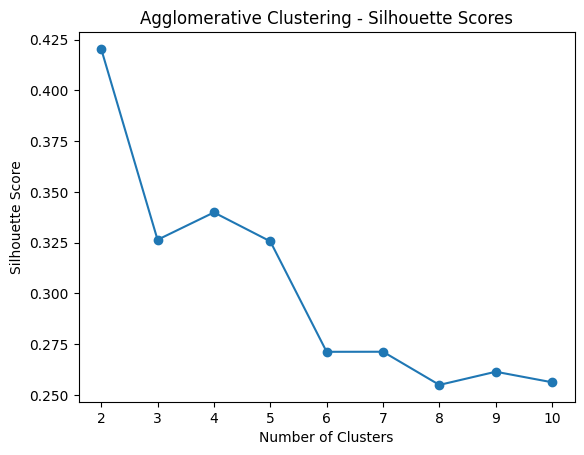

In [249]:
smiles_list = df['SMILES']
def extract_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        descriptors = [Descriptors.MolWt(mol), Descriptors.TPSA(mol), Descriptors.NumHAcceptors(mol), Descriptors.NumHDonors(mol)]
        return descriptors
    else:
        return [None] * 4  # Return None for invalid SMILES

# Apply the function to each SMILES in the DataFrame
descriptors_df = pd.DataFrame(smiles_list.apply(extract_descriptors).tolist(),
                               columns=['MolecularWeight', 'TopologicalPolarSurfaceArea', 'NumHAcceptors', 'NumHDonors'])

# Concatenate the original DataFrame with the extracted descriptors
df = pd.concat([df, descriptors_df], axis=1)

# Select the relevant columns as features for clustering
features = df[['MolecularWeight', 'TopologicalPolarSurfaceArea', 'NumHAcceptors', 'NumHDonors']]

# Choose the number of clusters (adjust as needed)
cluster_range = range(2, 11)  # Example range, adjust as needed
silhouette_scores = []

# Apply Agglomerative Hierarchical Clustering for different cluster numbers
for num_clusters in cluster_range:
    clustering = AgglomerativeClustering(n_clusters=num_clusters, linkage='ward')
    df['cluster'] = clustering.fit_predict(features)

    # Calculate silhouette score
    silhouette = silhouette_score(features, df['cluster'])
    silhouette_scores.append(silhouette)

# Visualize silhouette scores
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.title('Agglomerative Clustering - Silhouette Scores')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()
df=df1

# Applying Spectral Clustering

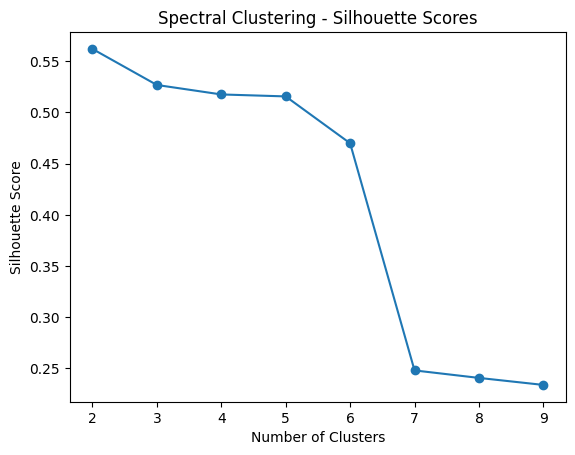

Optimal Number of Clusters: 2


In [250]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# Assuming 'SMILES' is the column in your DataFrame
smiles_list = df['SMILES']

# Function to extract molecular descriptors from SMILES
def extract_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        descriptors = [Descriptors.MolWt(mol), Descriptors.TPSA(mol), Descriptors.NumHAcceptors(mol), Descriptors.NumHDonors(mol)]
        return descriptors
    else:
        return [None] * 4  # Return None for invalid SMILES

# Apply the function to each SMILES in the DataFrame
descriptors_df = pd.DataFrame(smiles_list.apply(extract_descriptors).tolist(),
                               columns=['MolecularWeight', 'TopologicalPolarSurfaceArea', 'NumHAcceptors', 'NumHDonors'])

# Concatenate the original DataFrame with the extracted descriptors
df = pd.concat([df, descriptors_df], axis=1)

# Select the relevant columns as features for clustering
features = df[['MolecularWeight', 'TopologicalPolarSurfaceArea', 'NumHAcceptors', 'NumHDonors']]

# Use StandardScaler to scale the features
scaled_features = StandardScaler().fit_transform(features)

# Vary the number of clusters and calculate silhouette score
cluster_range = range(2, 10)  # You can adjust this range
silhouette_scores = []

for num_clusters in cluster_range:
    # Apply Spectral Clustering
    spectral = SpectralClustering(n_clusters=num_clusters, random_state=42)
    df['cluster'] = spectral.fit_predict(scaled_features)

    # Calculate silhouette score
    silhouette_avg = silhouette_score(scaled_features, df['cluster'])
    silhouette_scores.append(silhouette_avg)

# Plot silhouette scores
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.title('Spectral Clustering - Silhouette Scores')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

# Find the optimal number of clusters with the highest silhouette score
optimal_clusters = cluster_range[np.argmax(silhouette_scores)]
print(f"Optimal Number of Clusters: {optimal_clusters}")
df=df1

# Again DBSCAN Clustering technique

In [276]:
df=df.drop(['cluster','ensemble_cluster'],axis=1)

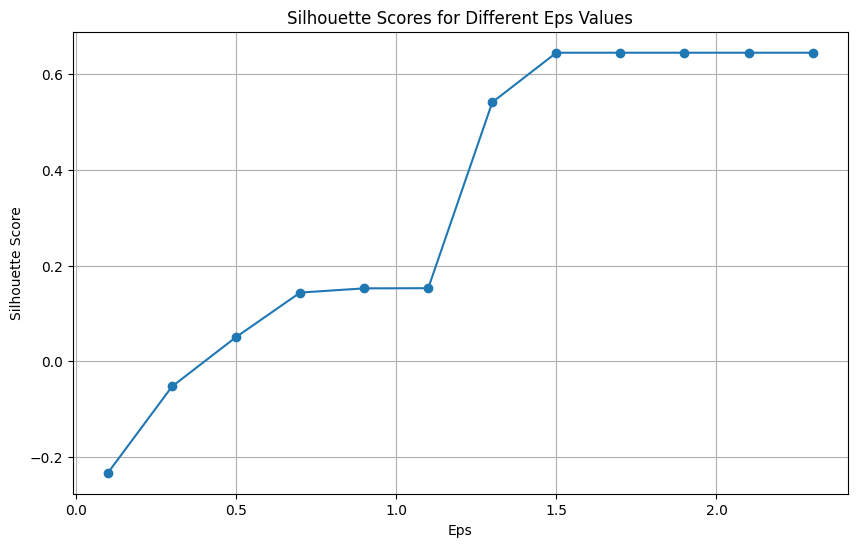

In [278]:
features = df[['MolecularWeight', 'TopologicalPolarSurfaceArea', 'NumHAcceptors', 'NumHDonors']]

# Standardize the features
scaler = StandardScaler()
features_standardized = scaler.fit_transform(features)

# Define a range of eps values
eps_values = np.arange(0.1, 2.5, 0.2)

# Initialize lists to store silhouette scores
silhouette_scores = []

# Iterate over different eps values
for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=5)  # Adjust min_samples as needed
    cluster_labels = dbscan.fit_predict(features_standardized)
    silhouette = silhouette_score(features_standardized, cluster_labels)
    silhouette_scores.append(silhouette)

# Plot the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(eps_values, silhouette_scores, marker='o', linestyle='-')
plt.title('Silhouette Scores for Different Eps Values')
plt.xlabel('Eps')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()


In [226]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# Assuming 'df' is your DataFrame
features = df[['MolecularWeight', 'TopologicalPolarSurfaceArea', 'NumHAcceptors', 'NumHDonors']]

# Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=2, min_samples=5)
df['dbscan_cluster'] = dbscan.fit_predict(scaled_features)

# Check the number of unique clusters
num_clusters = len(set(df['dbscan_cluster']))

if num_clusters > 1:
    # Calculate Silhouette Score if there are more than one cluster
    silhouette_avg = silhouette_score(scaled_features, df['dbscan_cluster'])
    print(f"Silhouette Score: {silhouette_avg}")
else:
    print("Only one cluster found. Silhouette score cannot be calculated.")
df=df.drop(['ensemble_cluster'],axis=1)
df

Only one cluster found. Silhouette score cannot be calculated.


In [266]:
features = df[['MolecularWeight', 'TopologicalPolarSurfaceArea', 'NumHAcceptors', 'NumHDonors']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
dbscan = DBSCAN(eps=2, min_samples=5)
df['dbscan_cluster'] = dbscan.fit_predict(scaled_features)
silhouette_avg = silhouette_score(scaled_features, df['dbscan_cluster'])
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.6442066043977905


# Initilaizing models for ensembling

In [267]:
scaled_features = StandardScaler().fit_transform(features)
dbscan = DBSCAN(eps=2, min_samples=5)
spectral = SpectralClustering(n_clusters=2, random_state=42)
kmeans = KMeans(n_clusters=3, random_state=42)
agglomerative = AgglomerativeClustering(n_clusters=3)
birch = Birch(n_clusters=3, threshold=0.5, branching_factor=50)
dbscan_clusters = dbscan.fit_predict(scaled_features)
spectral_clusters = spectral.fit_predict(scaled_features)
kmeans_clusters = kmeans.fit_predict(scaled_features)
birch_clusters = birch.fit_predict(scaled_features)
agglomerative_clusters = agglomerative.fit_predict(scaled_features)
df=df.drop(['dbscan_cluster'],axis=1)
df

# Applying Ensembling of DBScan and Birch

In [270]:
ensemble_clusters = np.vstack((dbscan_clusters, birch_clusters))
final_clusters = np.apply_along_axis(lambda x: np.argmax(np.bincount(x[x != -1])), axis=0, arr=ensemble_clusters)
df['ensemble_cluster'] = final_clusters
print("Final Cluster Assignments:")
print(df[['SMILES', 'ensemble_cluster']])
non_noise_df = df[df['ensemble_cluster'] != -1]
non_noise_features = scaled_features[df['ensemble_cluster'] != -1]
silhouette_score_value = silhouette_score(non_noise_features, non_noise_df['ensemble_cluster'])
print(f'Silhouette Score: {silhouette_score_value}')
df=df1

Final Cluster Assignments:
                                        SMILES  ensemble_cluster
0       CCCS(=O)c1ccc2[nH]c(=NC(=O)OC)[nH]c2c1                 0
1         CC(C)(C)C(=O)C(Oc1ccc(Cl)cc1)n1ccnc1                 0
2          Cc1c(Cl)cccc1Nc1ncccc1C(=O)OCC(O)CO                 0
3             Cn1cnc2c1c(=O)n(CC(O)CO)c(=O)n2C                 0
4               CC1Oc2ccc(Cl)cc2N(CC(O)CO)C1=O                 0
...                                        ...               ...
4995              Nc1ncnc(Nc2ccc(Cl)c(Cl)c2)n1                 0
4996  Cc1cc(NC(=O)c2ccc(S(=O)(=O)N(C)C)cc2)no1                 0
4997    Cc1ccc(Sc2c(C)nn(C(=O)c3cccnc3)c2C)cc1                 0
4998            O=C(c1cc(F)c(F)cc1Cl)N1CCCCCC1                 0
4999    Cc1ccccc1-c1nnn(CC(=O)Nc2cccc(C)c2C)n1                 0

[5000 rows x 2 columns]
Silhouette Score: 0.6442066043977477


# Applying ensemble of KMeans and Birch 

In [273]:
ensemble_clusters = np.vstack((kmeans_clusters, birch_clusters))
final_clusters = np.apply_along_axis(lambda x: np.argmax(np.bincount(x[x != -1])), axis=0, arr=ensemble_clusters)
df['ensemble_cluster'] = final_clusters
print("Final Cluster Assignments:")
print(df[['SMILES', 'ensemble_cluster']])
non_noise_df = df[df['ensemble_cluster'] != -1]
non_noise_features = scaled_features[df['ensemble_cluster'] != -1]
silhouette_score_value = silhouette_score(non_noise_features, non_noise_df['ensemble_cluster'])
print(f'Silhouette Score: {silhouette_score_value}')
scaled_features = StandardScaler().fit_transform(features)
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)
df=df1

Final Cluster Assignments:
                                        SMILES  ensemble_cluster
0       CCCS(=O)c1ccc2[nH]c(=NC(=O)OC)[nH]c2c1                 0
1         CC(C)(C)C(=O)C(Oc1ccc(Cl)cc1)n1ccnc1                 0
2          Cc1c(Cl)cccc1Nc1ncccc1C(=O)OCC(O)CO                 0
3             Cn1cnc2c1c(=O)n(CC(O)CO)c(=O)n2C                 0
4               CC1Oc2ccc(Cl)cc2N(CC(O)CO)C1=O                 0
...                                        ...               ...
4995              Nc1ncnc(Nc2ccc(Cl)c(Cl)c2)n1                 0
4996  Cc1cc(NC(=O)c2ccc(S(=O)(=O)N(C)C)cc2)no1                 1
4997    Cc1ccc(Sc2c(C)nn(C(=O)c3cccnc3)c2C)cc1                 0
4998            O=C(c1cc(F)c(F)cc1Cl)N1CCCCCC1                 0
4999    Cc1ccccc1-c1nnn(CC(=O)Nc2cccc(C)c2C)n1                 0

[5000 rows x 2 columns]
Silhouette Score: 0.21237232297048214


# Applying ensemble of DBSCAN and Spectral clustering 

In [274]:
scaled_features = StandardScaler().fit_transform(features)
ensemble_clusters = np.vstack((dbscan_clusters, spectral_clusters))
final_clusters = np.apply_along_axis(lambda x: np.argmax(np.bincount(x[x != -1])), axis=0, arr=ensemble_clusters)
df['ensemble_cluster'] = final_clusters
print("Final Cluster Assignments:")
print(df[['SMILES', 'ensemble_cluster']])
non_noise_df = df[df['ensemble_cluster'] != -1]
non_noise_features = scaled_features[df['ensemble_cluster'] != -1]
silhouette_score_value = silhouette_score(non_noise_features, non_noise_df['ensemble_cluster'])
print(f'Silhouette Score: {silhouette_score_value}')
df=df1

Final Cluster Assignments:
                                        SMILES  ensemble_cluster
0       CCCS(=O)c1ccc2[nH]c(=NC(=O)OC)[nH]c2c1                 0
1         CC(C)(C)C(=O)C(Oc1ccc(Cl)cc1)n1ccnc1                 0
2          Cc1c(Cl)cccc1Nc1ncccc1C(=O)OCC(O)CO                 0
3             Cn1cnc2c1c(=O)n(CC(O)CO)c(=O)n2C                 0
4               CC1Oc2ccc(Cl)cc2N(CC(O)CO)C1=O                 0
...                                        ...               ...
4995              Nc1ncnc(Nc2ccc(Cl)c(Cl)c2)n1                 0
4996  Cc1cc(NC(=O)c2ccc(S(=O)(=O)N(C)C)cc2)no1                 0
4997    Cc1ccc(Sc2c(C)nn(C(=O)c3cccnc3)c2C)cc1                 0
4998            O=C(c1cc(F)c(F)cc1Cl)N1CCCCCC1                 0
4999    Cc1ccccc1-c1nnn(CC(=O)Nc2cccc(C)c2C)n1                 0

[5000 rows x 2 columns]
Silhouette Score: 0.6442066043977477


# Finally we got a good silhouette score of nearly 0.65 in Applying ensemble of DBSCAN and Spectral clustering in random sampling.

# Thank You for reading